In [1]:
import os
import sys
import warnings
warnings.simplefilter("error", RuntimeWarning)
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from scipy.stats import norm
import plot_settings as plot_settings

In [2]:
# Angular distribution described in
# section 6.8 cowel.
def pdf(x, a, b, x_max, x_min):
    numerator = 1 + a * x + b * x**2
    normalization = (x_max-x_min) + (a/2)*(x_max**2-x_min**2) + (b/3)*(x_max**3-x_min**3)
    result = numerator / normalization

    return result

# This function performs a safe logarithmic calculation. 
# It wraps np.log in a try-except block. 
# If an exception occurs, the function returns 
# a large value to penalize invalid inputs.
def safe_log(x, a, b, x_max, x_min):
    try:
        return np.log(pdf(x, a, b, x_max, x_min)) 
    except Warning as e:
        return np.log(1e-10)
    

# Log-likelihood function
def log_likelihood(data, x_min, x_max):
    def log_likelihood_lambda(params):
        a, b = params
        likelihoods = [
            safe_log(x, a, b, x_max, x_min)
            for x in data
        ]
        return -np.sum(likelihoods) 
    return lambda params: log_likelihood_lambda(params)

def estimate_a_b(data):
    # Parameter estimation with initial values
    initial_guess = [0.5, 0.5]
    x_min = np.min(data)
    x_max = np.max(data)

    result = minimize(
        log_likelihood(data,x_min,x_max), 
        initial_guess, 
        method="BFGS"
    )

    # Results
    a, b = result.x   
    

    # Errors estimated from the covariance matrix
    cov_matrix = result.hess_inv
    errors = np.sqrt(np.diag(cov_matrix))
    covariance = cov_matrix[0, 1]

    resulting_pdf = lambda x : pdf(x, a, b, x_max, x_min) 

    return a, b, errors, covariance, resulting_pdf


Stima di a: 0.298 +/- 0.180
Stima di b: 0.929 +/- 0.437
Stima covarianza 0.016
Stima coefficiente covarianza 0.206


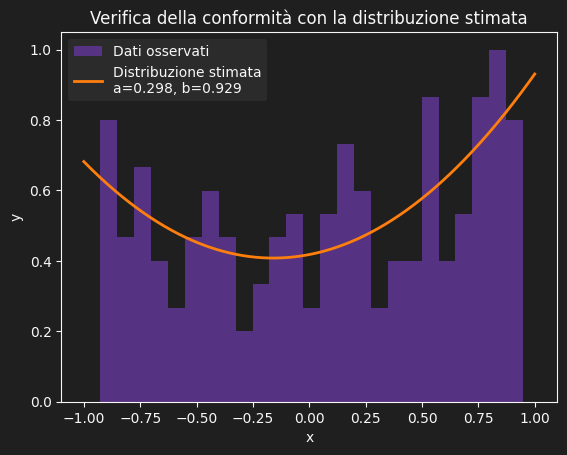

In [3]:
data = np.loadtxt("data_proj_one.dat")

a, b, errors, covariance, estimated_pdf = estimate_a_b(data)

print(f"Stima di a: {a:.3f} +/- {errors[0]:.3f}")
print(f"Stima di b: {b:.3f} +/- {errors[1]:.3f}")
print(f"Stima covarianza {covariance:.3f}")
correlation_coeff = covariance /(errors[0] * errors[1])
print(f"Stima coefficiente covarianza {correlation_coeff:.3f}")

fig, ax = plot_settings.figure_ax()

# Generation of points for the estimated distribution
x_values = np.linspace(-1, 1, 500)
pdf_values = [estimated_pdf(x) for x in x_values]

#1 5

# Plot comparison between histogram of data and the estimated curve
ax.hist(data, bins=25, density=True, alpha=0.9, color=plot_settings.color(1), label='Dati osservati')
ax.plot(x_values, pdf_values, plot_settings.color(5), linewidth=2, label=f'Distribuzione stimata\na={a:.3f}, b={b:.3f}')
plot_settings.title('Verifica della conformità con la distribuzione stimata'),
ax.set_xlabel('x')
ax.set_ylabel('Densità di probabilità')

plot_settings.set_plot_theme(ax)

plt.show()

In [4]:
# This function is used to get the
# the estimated pdf maximum.
def get_pdf_maximum(e_pdf):    
    return np.max([e_pdf(-1),e_pdf(1)])

# Function for random generation
# using the Monte Carlo method
def generate_random_monte_carlo(pdf, pdf_maximum, n_samples, x_min, x_max):
    samples = []
    while len(samples) < n_samples:
        sample = random.uniform(x_min,x_max)
        random_picker = random.uniform(0,pdf_maximum)
        if(pdf(sample) >= random_picker):
            samples.append(sample)
    return samples

In [5]:
estimated_a = []
estimated_a_error = []
estimated_b = []
estimated_b_error = []
estimated_cov = []

data_max = data.max()
data_min = data.min()

pdf_max = get_pdf_maximum(estimated_pdf)
d = False
# Making 500 simulations
for _ in range(1000):
    new_x = generate_random_monte_carlo(estimated_pdf, pdf_max, 500, data_min, data_max)

    new_a,new_b, errors_mc, covariance, npdf = estimate_a_b(new_x)

    estimated_a.append(new_a)
    estimated_b.append(new_b)
    estimated_cov.append(covariance)
    estimated_a_error.append(errors_mc[0])
    estimated_b_error.append(errors_mc[1])

mean_covariance = np.mean(estimated_cov)
mean_error_a = np.mean(estimated_a_error)
mean_error_b = np.mean(estimated_b_error)
print(f"Stima covarianza con MC {mean_covariance:.3f}")
mean_correlation_coeff = mean_covariance /(mean_error_a * mean_error_b)
print(f"Stima coefficiente covarianza con MC {mean_correlation_coeff:.3f}")

Stima covarianza con MC 0.007
Stima coefficiente covarianza con MC 0.192


-5.6471906797102545


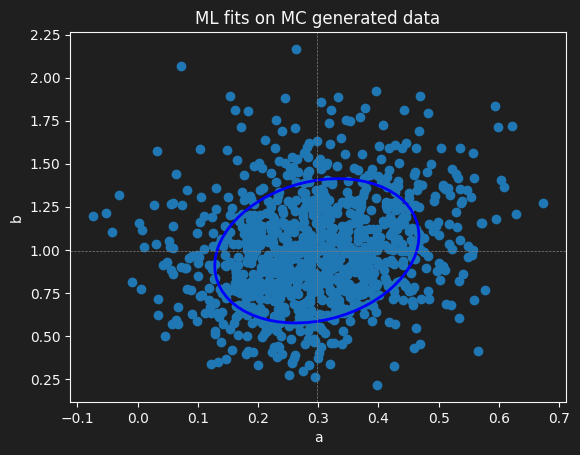

In [6]:
# Visualizations of data generated via Monte Carlo
from matplotlib.patches import Ellipse
mc_a = np.mean(estimated_a)
mc_b = np.mean(estimated_b)


sigma_alpha = mean_error_a 
sigma_beta = mean_error_b   
rho = correlation_coeff  
alpha_hat = mc_a    
beta_hat = mc_b     


# Calcolo dell'angolo φ
tan_2phi = (2 * rho * sigma_alpha * sigma_beta) / (sigma_alpha**2 - sigma_beta**2)
phi = 0.5 * np.arctan(tan_2phi)

print(np.degrees(phi))
# Creazione della figura
fig, ax = plot_settings.figure_ax()

plot_settings.title('ML fits on MC generated data')    
ax.scatter(estimated_a,estimated_b,)


# Calcolo dei semiassi principali
a = np.sqrt(1 / (1 - rho**2)) * sigma_alpha  # semiasse maggiore
b = np.sqrt(1 / (1 - rho**2)) * sigma_beta   # semiasse minore

# Calcolo dei termini comuni
rho2 = rho ** 2
term_common = 4 * rho2 * sigma_alpha**2 * sigma_beta**2 + sigma_alpha**4 - 2 * sigma_alpha**2 * sigma_beta**2 + sigma_beta**4
sqrt_term = np.sqrt(term_common)

# Autovalori
eigenvalue1 = (-(rho - 1) * (rho + 1) * sqrt_term + (rho2 - 1) * (-sigma_alpha**2 - sigma_beta**2)) /(2 * sigma_alpha**2 * sigma_beta**2 * (rho2 - 1))
eigenvalue2 = ((rho - 1) * (rho + 1) * sqrt_term - (rho2 - 1) * (sigma_alpha**2 + sigma_beta**2)) /(2 * sigma_alpha**2 * sigma_beta**2 * (rho2 - 1))
a1 = np.sqrt(2 / abs(eigenvalue1))
a2 = np.sqrt(2 / abs(eigenvalue2))

# Ellisse
ellipse = Ellipse((alpha_hat, beta_hat), width=2*a1, height=2*a2, angle=np.degrees(phi),
                  edgecolor='blue', facecolor='none', lw=2)
ax.add_patch(ellipse)

# Assi e dettagli

ax.axhline(beta_hat, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(alpha_hat, color='gray', linestyle='--', linewidth=0.5)

plot_settings.set_plot_theme(ax, xlabel='a',ylabel='b', show_legend=False)

In [55]:
def plot_marginal_distribution(values, title, xlabel) : 
    _, ax = plot_settings.figure_ax()
    ax.hist(values, bins=60, density=True, alpha=0.6, color=plot_settings.color(1))
    plot_settings.title(title) 
    ax.set_xlabel(xlabel)

    mean = np.mean(values)
    error = np.std(values)

    x = np.linspace(mean - 4*error, mean + 4*error, 1000)
    pdf = norm.pdf(x, mean, error)

    plt.plot(x, pdf, lw=2, label="Gaussian fit", c=plot_settings.color(5))
    plot_settings.set_plot_theme(ax)
    plt.show()
    print(f"Estimated {xlabel}: {mean:.3f} +/- {error:.3f}")

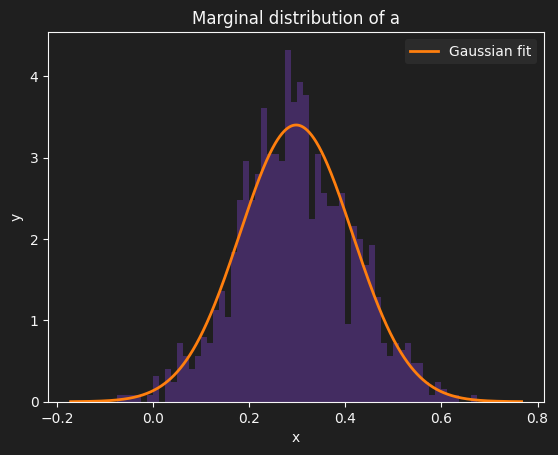

Estimated a: 0.298 +/- 0.117


In [56]:
plot_marginal_distribution(estimated_a, 'Marginal distribution of a', 'a')

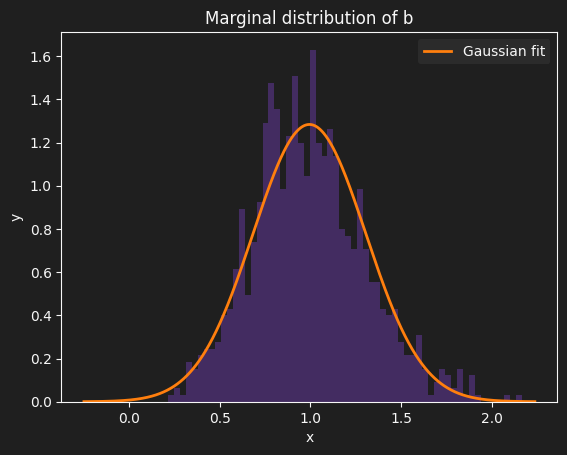

Estimated b: 0.994 +/- 0.311


In [57]:
plot_marginal_distribution(estimated_b, 'Marginal distribution of b', 'b')